# BBC News Classification

This project involves participating in the Kaggle competition "BBC News Classification." The goal is to categorize news articles using matrix factorization techniques. The project includes the following steps:

1. **Exploratory Data Analysis (EDA)**: Conduct an in-depth analysis of the dataset to understand its structure and features.
2. **Model Building and Training**: Develop and train a model to classify news articles into appropriate categories.
3. **Comparison with Supervised Learning**: Compare the performance of matrix factorization with traditional supervised learning methods.

# Imports & Setup

First, we need to import the data. We will be using the Kaggle API. To do this, you will need your own API key. Then uncomment the command line or copy it into your terminal. 

In [1]:
# !kaggle competitions download -c learn-ai-bbc

In [2]:
# !pip install ydata-profiling
# !pip install ipywidgets # needed for ProfileReport

Now import the dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Optional (for Profile Report for visualization)
from ydata_profiling import ProfileReport
import ipywidgets

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [4]:
train = pd.read_csv('data/BBC News Train.csv')
test = pd.read_csv('data/BBC News Test.csv')
sample_solution = pd.read_csv("data/BBC News Sample Solution.csv")

# Exploratory Data Analysis (EDA)

In this section, we perform Exploratory Data Analysis (EDA) to gain insights into the training dataset. The steps include:

- **Visualizing the Raw Data**:
  - Inspecting individual records to understand the structure and content of the dataset.
  - Viewing dataset information to identify data types, non-null counts, and basic statistics.
  - Creating a histogram to visualize the distribution of data across different categories.
  - Drawing conclusions about the dataset based on visualizations and statistics.

### Key Findings

From the EDA, we observe the following:

- The dataset contains **1490 news articles** grouped into **5 topics**.
- There are **no null, NaN, or missing values** in the dataset.
- The classes are **relatively balanced**, ensuring that no single category dominates the dataset.
- The most common topic is **sports**, while the least common topic is **tech**.
- There were **50 non-unique articles**, as identified by the `train.nunique()` function.
- After tokenizing the documents, the **word count statistics** for the articles are:
  - **Maximum** number of words: 3345
  - **Minimum** number of words: 90
  - **Average** number of words: 385


In [5]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [7]:
train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [8]:
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [10]:
test.nunique()

ArticleId    735
Text         722
dtype: int64

Find the number of words per article

In [11]:
train['Num_Words'] = train['Text'].apply(lambda x: len(x.split()))

max_words = train['Num_Words'].max()
min_words = train['Num_Words'].min()
avg_words = train['Num_Words'].mean()

print(f"Max words: {max_words}\nMin words: {min_words},\nAvg words: {avg_words}")

Max words: 3345
Min words: 90,
Avg words: 385.01275167785235


In [12]:
test['Num_Words'] = test['Text'].apply(lambda x: len(x.split()))

max_words = test['Num_Words'].max()
min_words = test['Num_Words'].min()
avg_words = test['Num_Words'].mean()

print(f"Max words: {max_words}\nMin words: {min_words},\nAvg words: {avg_words}")

Max words: 4492
Min words: 126,
Avg words: 401.0040816326531


Words per article in each set of data

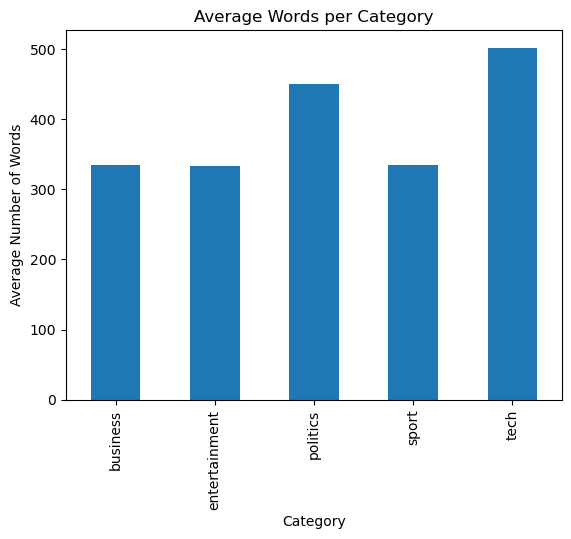

In [13]:
%matplotlib inline

avg_words_per_category = train.groupby('Category')['Num_Words'].mean()

avg_words_per_category.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Average Number of Words')
plt.title('Average Words per Category')

plt.xticks(rotation=90)

plt.show()

Display the number of articles per topic

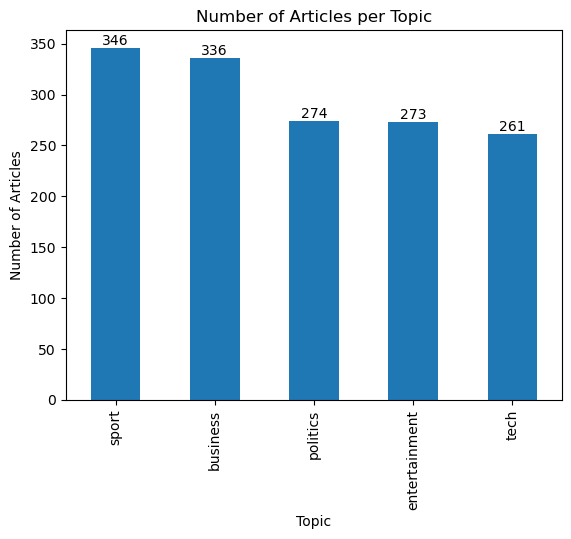

In [14]:
%matplotlib inline

train['Category'].value_counts().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Topic')

plt.xticks(rotation=90)

for i, v in enumerate(train['Category'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [15]:
classes = train.Category.value_counts()
classes

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

Drop any duplicates to give a more accurate report

In [16]:
train = train.drop_duplicates(subset=['Text'], ignore_index=True)
test = test.drop_duplicates(subset=['Text'], ignore_index=True)

Create a profile report after removing stop words

In [17]:
profile = ProfileReport(train, title="Test Profiling Report") #, explorative=True)
profile.to_notebook_iframe()
profile.to_file("test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Create the labels

In [18]:
labels = dict(zip(train['Category'].unique().tolist(), list(range(5))))
labels

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [19]:
train['Label'] = [labels[l] for l in train['Category']]
train.head()

,ArticleId,Text,Category,Num_Words,Label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,0
1,154,german business confidence slides german busin...,business,325,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,0
3,1976,lifestyle governs mobile choice faster bett...,tech,634,1
4,917,enron bosses in $168m payout eighteen former e...,business,355,0


In [20]:
y_labels = train['Label'].tolist()

# Create Embeddings

Using `TfidfVectorizer`, we will create vector representations of text that turn natural language into numerical vectors. I use the term "Embeddings" loosely here as we are creating a sparse matrix.

### Understanding TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that reflects the importance of a term in a document relative to a collection or corpus of documents. TF-IDF is commonly used in information retrieval and text mining tasks, such as document classification, clustering, and search engine ranking.

### Components of TF-IDF

1. **Term Frequency (TF)**: This measures how frequently a term appears in a document. The more frequently a term occurs in a document, the higher its TF value. TF can be calculated in different ways:
    - **Raw count**: The number of times a term appears in a document.
    - **Term frequency**: 
    $$
      \text{TF}(t, d) = \frac{\text{count of } t \text{ in } d}{\text{total terms in } d}
    $$
    - **Logarithmic scaling**: 
      $$
      \text{TF}(t, d) = 1 + \log(\text{count of } t \text{ in } d)
      $$ 
      (if the count > 0, else 0).

2. **Inverse Document Frequency (IDF)**: This measures how important a term is across the entire corpus. Terms that are common across many documents have a lower IDF, while rare terms have a higher IDF.
    - **IDF**: 
      $$
      \text{IDF}(t, D) = \log\left(\frac{N}{1 + \text{df}(t)}\right)
      $$
        - $N$ is the total number of documents.
        - $\text{df}(t)$ is the number of documents containing the term $t $.

### Calculating TF-IDF

By combining TF and IDF, we obtain the TF-IDF value:
$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$
This value represents the importance of a term in a specific document relative to the entire document collection. Terms with higher TF-IDF values are considered more significant for representing the document's content.

### Using `TfidfVectorizer`

In the provided code, the `TfidfVectorizer` from the scikit-learn library is used to create vector representations. `TfidfVectorizer` converts a collection of raw documents into a matrix of TF-IDF features. Here’s how it works:
- **Tokenization**: Splits the text into words or tokens.
- **Counting**: Counts the term frequencies for each document.
- **IDF weighting**: Applies IDF weighting to each term.

The resulting TF-IDF matrix is a sparse representation of the documents, which can be used as input for various machine learning algorithms or other natural language processing tasks.

In [21]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# dtm: Document Term Matrix
dtm = vectorizer.fit_transform(train.Text)

feature_names = vectorizer.get_feature_names_out()

dtm_df = pd.DataFrame(dtm.toarray(), columns=feature_names)
print('Document Term Matrix size:', dtm_df.shape)
dtm_df.head()

Document Term Matrix size: (1440, 13752)


,00,000,000m,000th,007,01,0100,0130,028,03,...,zoe,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Construction

In this section, we construct and fit a Non-negative Matrix Factorization (NMF) model to the document-term matrix (DTM) to identify latent topics within the corpus.

### NMF Model Fitting

We initialize and fit the NMF model with the following parameters:
- **n_components**: 5 (number of topics)
- **init**: 'nndsvda' (initialization method)
- **solver**: 'mu' (multiplicative update solver)
- **beta_loss**: 'kullback-leibler' (divergence function)
- **l1_ratio**: 0.1 (regularization parameter)
- **random_state**: 0 (for reproducibility)
- **max_iter**: 200 (maximum number of iterations)

After fitting the model, we obtain:
- **W matrix**: Document-topic matrix representing the strength of each topic in each document.
- **H matrix**: Topic-term matrix representing the strength of each term in each topic.

### Top Features Visualization

We create a function to visualize the top features for each topic:
- **top_features**: This function takes the H matrix, feature names, and topic labels to plot the top features for each topic.

### Label Predictions

We transform the document-term matrix using the fitted NMF model to obtain the document-topic matrix (**W**). We then:
- Convert the document-topic matrix into a DataFrame for further analysis.
- Predict the labels for each document by identifying the topic with the highest weight.

### Label Permutation

We define a function to find the best permutation of predicted labels to match the true labels:
- **label_permute**: This function evaluates all possible permutations of the predicted labels to maximize the accuracy score against the true labels.

Finally, we compute and print the best accuracy score achieved by the optimal label permutation.

This approach ensures that our topic modeling results are aligned as closely as possible with the actual categories of the news articles.


In [22]:
nmf = NMF(n_components=5, init='nndsvda', solver='mu', beta_loss='kullback-leibler', l1_ratio=0.1, random_state=0, max_iter=200).fit(dtm)
W = nmf.transform(dtm)
H = nmf.components_

In [23]:
labels

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [24]:
def top_features(H: list, feature_names: list, labels: dict):
    """Plot the top features of each topic

    Args:
        H (list): Represents the learned topics
        feature_names (list): List of feature names
        labels (dict): Dictionary of labels
    """
    # print("Length of H: ", len(H))
    plt.figure(figsize=(24, 16))
    for i, topic in enumerate(H):
        # print("topic: ", i)
        plt.subplot(231 + i)
        ind = topic.argsort()[-20:]
        features = feature_names[ind]
        weights = topic[ind]

        plt.barh(features, weights, height=0.7)
        plt.yticks(fontsize=16)
        for key, val in labels.items():
            if val == i:
                topic = key.capitalize()
                
        plt.title(f'{topic}', fontsize=24)
    plt.tight_layout()

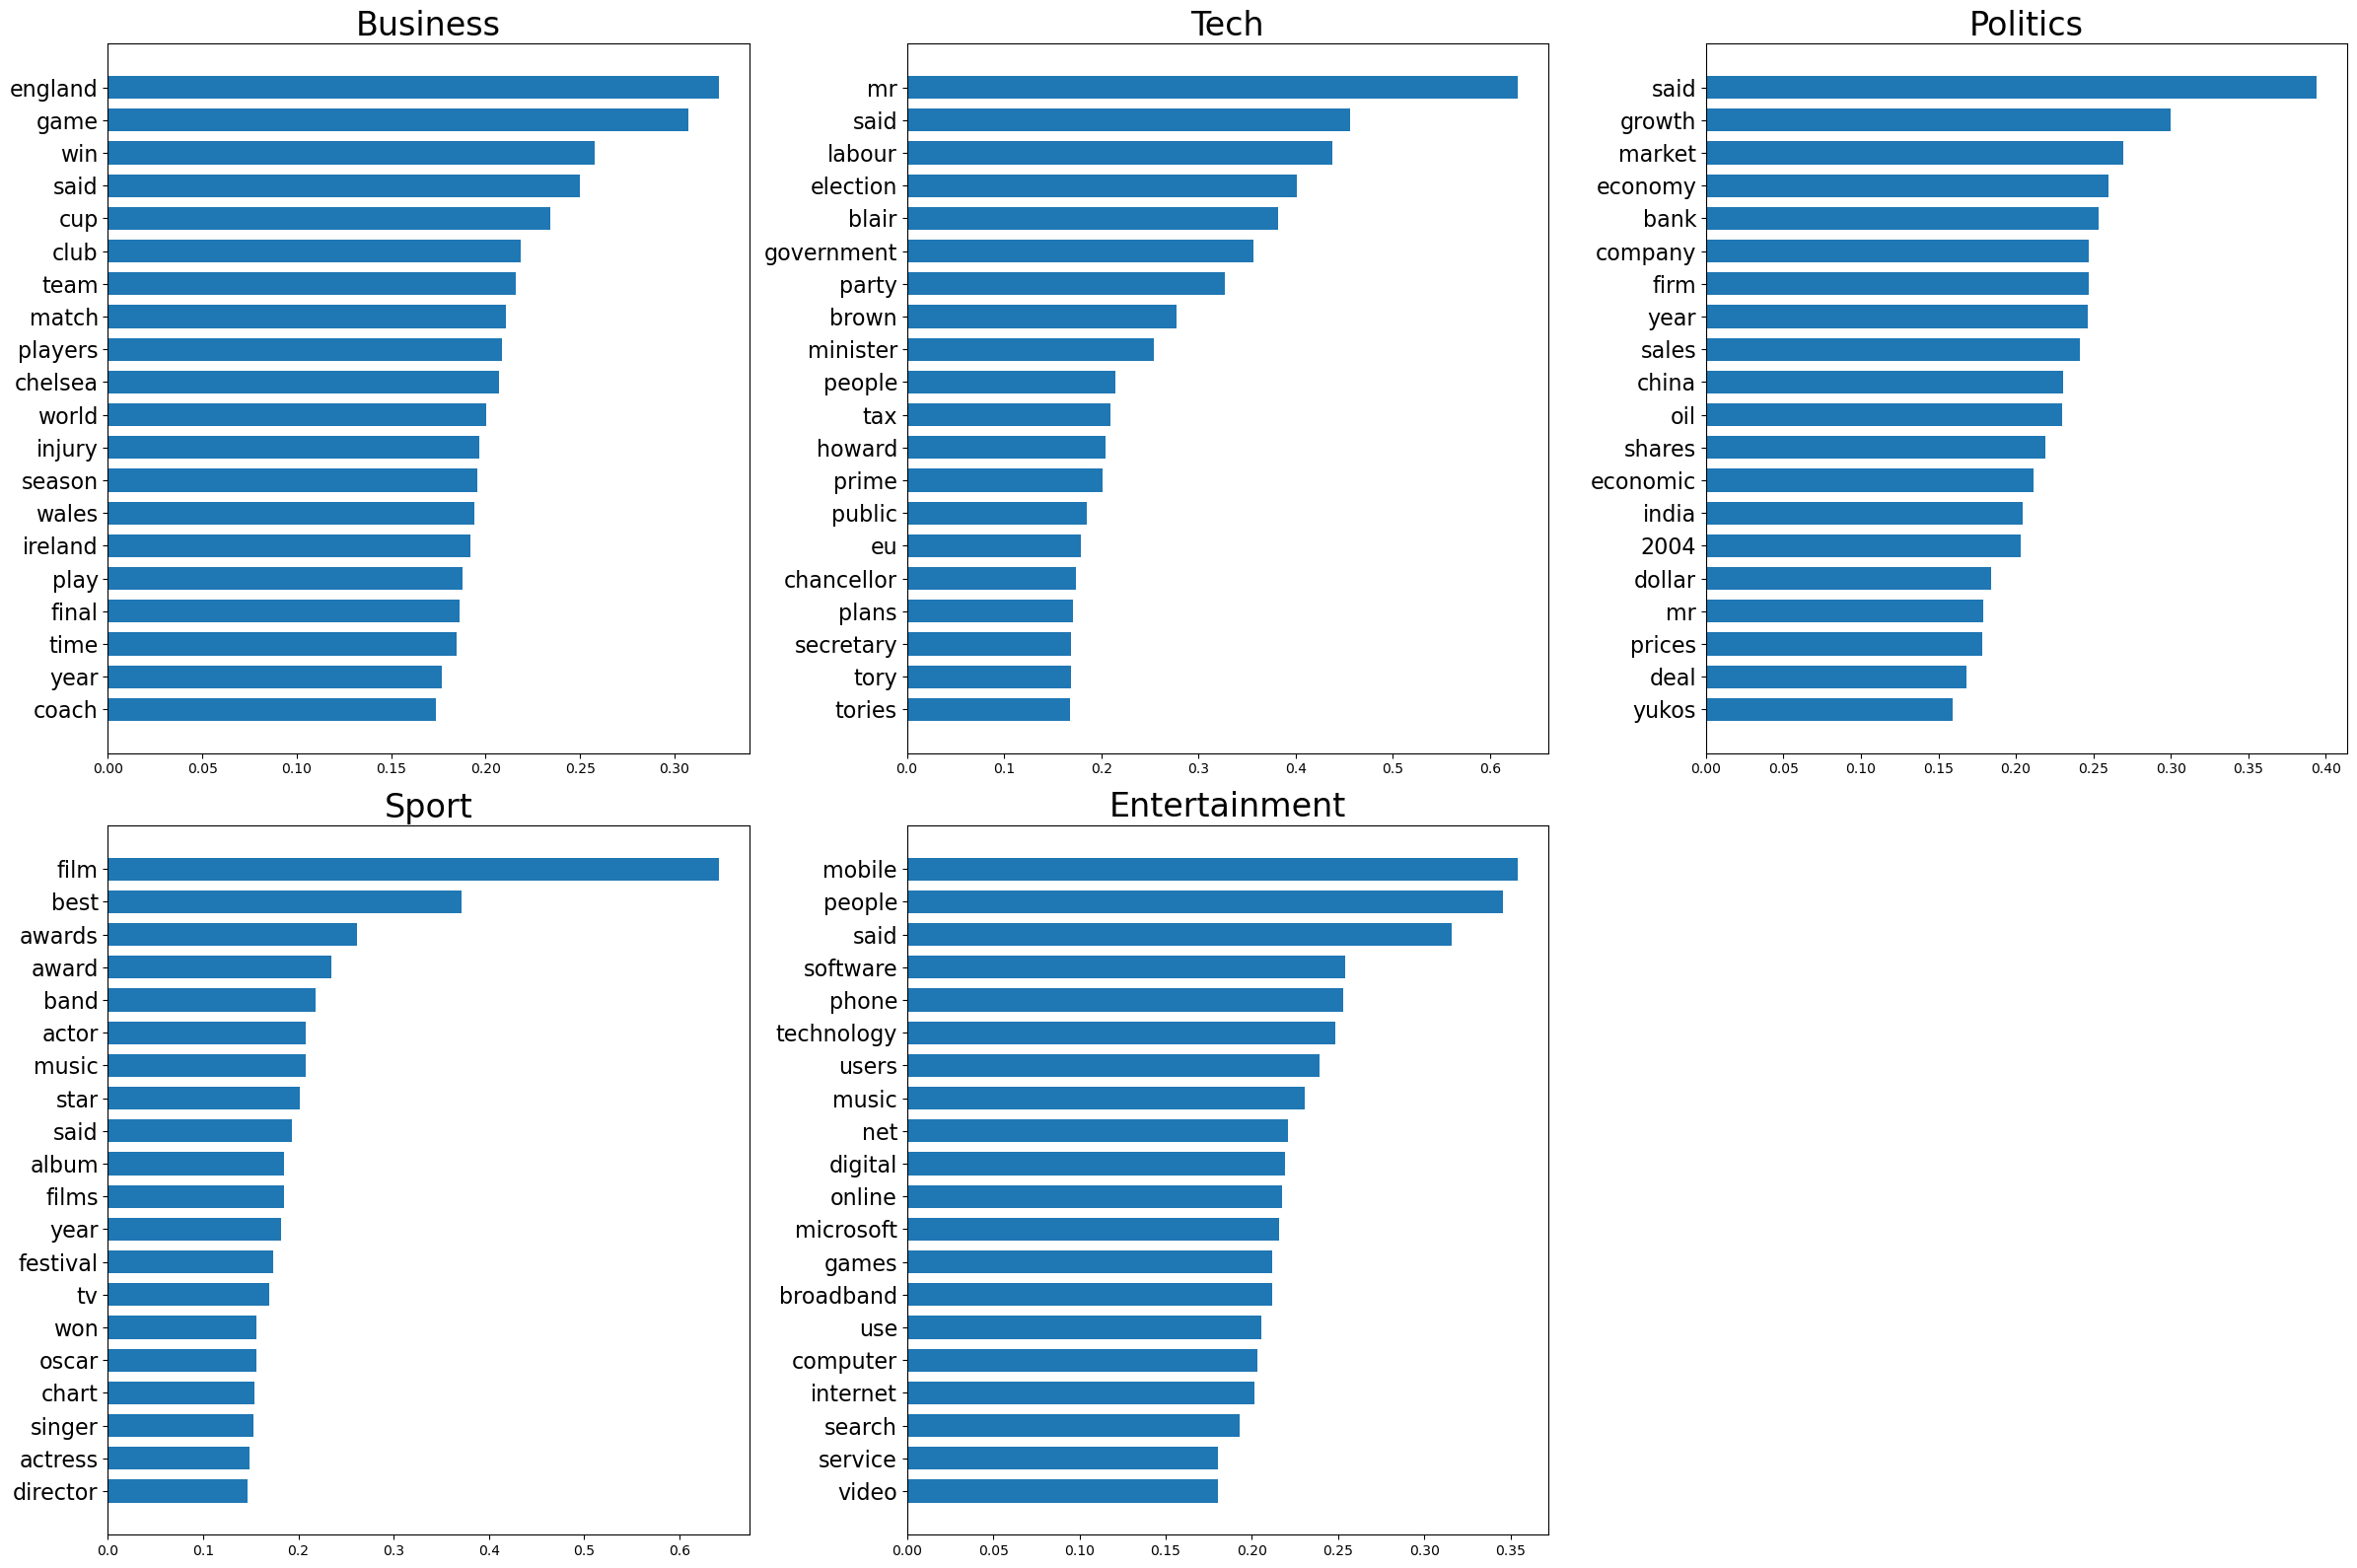

In [25]:
features = top_features(H[:, :len(feature_names)], feature_names, labels)

In [26]:
label_prediction = pd.DataFrame(W)
label_prediction

,0,1,2,3,4
0,9.178083e-13,3.999287e-07,1.080970e-01,3.248876e-06,5.334837e-09
1,5.038738e-15,4.007907e-08,1.403866e-01,2.116302e-18,7.823035e-13
2,2.156966e-07,4.891270e-02,9.355833e-02,1.816481e-08,6.127936e-05
3,2.645878e-14,1.021969e-11,5.247917e-13,3.251902e-12,1.483258e-01
4,8.966329e-08,3.340716e-03,1.241750e-01,1.383263e-08,1.626991e-06
...,...,...,...,...,...
1435,5.776790e-05,4.187881e-12,2.136039e-13,1.071213e-01,4.539597e-15
1436,1.093912e-05,2.370002e-07,1.954893e-05,1.263091e-01,3.335767e-02
1437,3.891970e-10,1.360256e-11,1.186950e-01,5.441283e-11,6.542320e-13
1438,1.011774e-08,8.945854e-14,6.986169e-05,9.652990e-10,1.551064e-01


In [27]:
predictions = np.argmax(W, axis=1)

In [28]:
def label_permute(y: list, yp: list):  
    """Permute the labels to maximize accuracy

    Args:
        y (list): list of labels
        yp (list): predicted labels

    Returns:
        best_accuracy, best_ordering (float, tuple): Returns the best accuracy and ordering
    """
    unique_labels = np.unique(yp)
    ordering = permutations(unique_labels)    
    best_accuracy = 0.0
    best_ordering = ''
    
    for order in ordering:
        # Create a mapping of yp according to order
        label_mapping = dict(zip(unique_labels, order))
        reordered_yp = np.array([label_mapping[lbl] for lbl in yp])
        
        curr_score = accuracy_score(y, reordered_yp)
        if curr_score > best_accuracy:
            best_accuracy = curr_score
            best_ordering = order
            
    return best_accuracy, best_ordering

In [29]:
best_accuracy, best_ordering = label_permute(y_labels, predictions)
print(best_accuracy)

0.9590277777777778


# Hyperparameter Turning
In this section, we optimize our model using Grid Search within a pipeline setup. The pipeline includes TF-IDF vectorization followed by NMF. Grid Search is employed to identify the best combination of hyperparameters for the TF-IDF vectorizer and the NMF model.

### Hyperparameter Grid

We define a grid of hyperparameters to search over:

#### TF-IDF Vectorizer Parameters:
- **max_df**: Maximum document frequency (0.95, 0.99)
- **min_df**: Minimum document frequency (2, 5)

#### NMF Model Parameters:
- **n_components**: Number of components (3, 5, 7)
- **beta_loss**: Loss function ('kullback-leibler', 'frobenius')
- **solver**: Solver method ('mu', 'cd')
- **max_iter**: Maximum number of iterations (200, 400)
- **alpha_W**: Regularization parameter for W (0.1, 0.5)
- **alpha_H**: Regularization parameter for H (0.1, 0.5)

### Custom Scoring Function
`scoring()` transforms the input data using the fitted estimator, predicts the categories by finding the component with the highest value, and then computes the accuracy based on the best label permutation.

### Grid Search Execution
We use Grid Search to find the optimal hyperparameter combination that maximizes the custom scoring function. This allows us to systematically explore the parameter space and identify the best-performing model configuration for our text classification task.

In [30]:
def scoring(estimator, x, y):
    """Scoring function to return the best_accuracy from label_permute

    Args:
        estimator (_type_): _description_
        x (Series): _description_
        y (Series): _description_

    Returns:
        best_accuracy (float): Returns the best accuracy
    """
    w = estimator.transform(x)
    predictions = np.argmax(w, axis=1)
    best_accuracy, best_ordering = label_permute(y, predictions)
    return best_accuracy

In [31]:
pipe = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
    ('nmf', NMF(init='nndsvda', random_state=0))
], memory=None)

params = [{
    # TFIDF Params
    'tfidfvectorizer__max_df': [0.95, 0.99],
    'tfidfvectorizer__min_df': [2, 5],
    # Model Params
    'nmf__n_components': [3, 5, 7],
    'nmf__beta_loss': ['kullback-leibler', 'frobenius'],
    'nmf__solver': ['mu', 'cd'],
    'nmf__max_iter': [200, 400],
    'nmf__alpha_W': [0.1, 0.5],
    'nmf__alpha_H': [0.1, 0.5]
}]

In [32]:
grid_search = GridSearchCV(pipe, param_grid=params, scoring=scoring, cv=5)
X = train['Text']
y = train['Label']
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nmf',
                                        NMF(init='nndsvda', random_state=0))]),
             param_grid=[{'nmf__alpha_H': [0.1, 0.5],
                          'nmf__alpha_W': [0.1, 0.5],
                          'nmf__beta_loss': ['kullback-leibler', 'frobenius'],
                          'nmf__max_iter': [200, 400],
                          'nmf__n_components': [3, 5, 7],
                          'nmf__solver': ['mu', 'cd'],
                          'tfidfvectorizer__max_df': [0.95, 0.99],
                          'tfidfvectorizer__min_df': [2, 5]}],
             scoring=<function scoring at 0x304c14040>)

In [33]:
best_params = grid_search.best_params_

print('Best parameters:', best_params)

Best parameters: {'nmf__alpha_H': 0.1, 'nmf__alpha_W': 0.1, 'nmf__beta_loss': 'kullback-leibler', 'nmf__max_iter': 200, 'nmf__n_components': 5, 'nmf__solver': 'mu', 'tfidfvectorizer__max_df': 0.95, 'tfidfvectorizer__min_df': 2}


In [34]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
best_dtm = vectorizer.fit_transform(train.Text)

best_model = NMF(n_components=5, init='nndsvda', solver='mu', beta_loss='kullback-leibler', alpha_H=0.1, alpha_W=0.1, max_iter=200, random_state=0)

# Train the model with the best hyperparameters
# best_model = NMF(**best_params)
best_model.fit(best_dtm)
best_model_W = best_model.transform(best_dtm)
best_model_H = best_model.components_

In [35]:
best_predictions = np.argmax(best_model_W, axis=1)
y = train['Label']
best_accuracy, best_ordering = label_permute(y, best_predictions)
print('Best NMF Accuracy:', round(best_accuracy, 3))

Best NMF Accuracy: 0.958


In [36]:
unique_labels = np.unique(predictions)
label_mapping = dict(zip(unique_labels, best_ordering))
reordered_yp = np.array([label_mapping[lbl] for lbl in predictions])

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'business'),
  Text(0, 1.5, 'entertainment'),
  Text(0, 2.5, 'politics'),
  Text(0, 3.5, 'sport'),
  Text(0, 4.5, 'tech')])

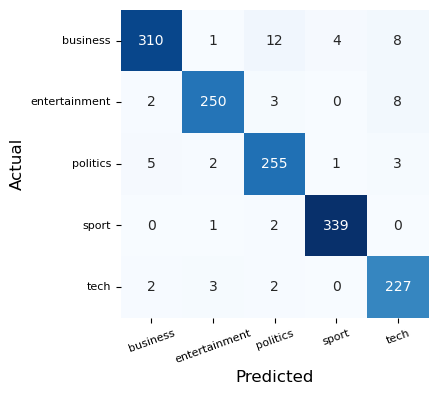

In [37]:
levels = pd.Index(labels)
cm = pd.crosstab(levels[y], levels[reordered_yp])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.0f', cbar=False)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8)

# Test Data
In this section, we apply our trained model to the test dataset to predict the categories of new, unseen articles. The steps include:

1. **Transforming the Test Data**:
   - Convert the text data in the test set into a document-term matrix (DTM) using the pre-fitted TF-IDF vectorizer.

2. **Applying the NMF Model**:
   - Use the best-performing NMF model to transform the DTM of the test set, resulting in a document-topic matrix (**test_W**).

3. **Predicting Labels**:
   - Predict the labels for each article by identifying the topic with the highest weight in the document-topic matrix.
   - Reorder the predicted labels using the optimal label mapping identified during the model training phase to ensure consistency with the training labels.

4. **Generating the Submission File**:
   - Map the reordered topic labels to their corresponding category names.
   - Create a submission DataFrame containing the article IDs and the predicted categories.
   - Save the submission DataFrame to a CSV file (`submission.csv`) for submission to the Kaggle competition.

In [38]:
dtm_test = vectorizer.transform(test['Text'])

test_W = best_model.fit_transform(dtm_test)
test_predictions = np.argmax(test_W, axis=1)

reordered_test_predictions = np.array([label_mapping.get(lbl, lbl) for lbl in test_predictions])
test_predicted_labels = levels[reordered_test_predictions]

In [39]:
submission = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': test_predicted_labels})

submission.to_csv('submission.csv', index=False)

## Comparing Supervised Learning Models
In this section, we compare the performance of various supervised learning models on the task of news article classification. The steps include:

1. **Splitting the Data**:
   - Divide the dataset into training and test sets using an 80/20 split.

2. **Transforming the Data**:
   - Convert the training and test text data into document-term matrices (DTMs) using the TF-IDF vectorizer.

3. **Training and Evaluating Models**:
   - **Random Forest Classifier**:
     - Train the model on the training DTM and corresponding labels.
     - Predict the labels for the test DTM.
     - Calculate and print the accuracy of the model on the test data.
   
   - **Gradient Boosting Classifier**:
     - Train the model on the training DTM and corresponding labels.
     - Predict the labels for the test DTM.
     - Calculate and print the accuracy of the model on the test data.

   - **Logistic Regression**:
     - Train the model on the training DTM and corresponding labels.
     - Predict the labels for the test DTM.
     - Calculate and print the accuracy of the model on the test data.

In [40]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train.Text, train.Category, test_size=0.2, random_state=42)

X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train_dtm, y_train)

# Predict on test data
y_pred_test = rf.predict(X_test_dtm)

# Calculate accuracy on test data
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))

Test Accuracy:  0.9513888888888888


In [42]:
gb = GradientBoostingClassifier()
gb.fit(X_train_dtm, y_train)

# Predict on test data
y_pred_test = gb.predict(X_test_dtm)

# Calculate accuracy on test data
print("Gradient Boosting Accuracy: ", accuracy_score(y_test, y_pred_test))

Gradient Boosting Accuracy:  0.9479166666666666


In [43]:
lr = LogisticRegression()
lr.fit(X_train_dtm, y_train)

# Predict on test data
y_pred_test = lr.predict(X_test_dtm)

# Calculate accuracy on test data
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred_test))

Logistic Regression Accuracy:  0.9722222222222222


# Findings
After evaluating the accuracies of various supervised learning models, it is clear that the Non-negative Matrix Factorization (NMF) approach is less effective compared to the Logistic Regression model. The results highlight that Logistic Regression outperforms other models in terms of accuracy:

#### Results:

| Model                        | Accuracy |
|------------------------------|----------|
| NMF                          |   95.8%  |
| GradientBoostingClassifier   |   94.8%  |
| RandomForestClassifier       |   95.1%  |
| LogisticRegression           |   97.2%  |

Logistic Regression achieves the highest accuracy, making it the most effective model for categorizing news articles in this dataset. While NMF performs well, it falls short of the accuracy obtained by Logistic Regression. This would highlight how a supervised learning method would be better suited for labeled data than unsupervised. 
